**Linear Regression**

Fold 1
  Train R²: 0.6040
  Test  R²: 0.6026
  Test  MSE: 126.77

Fold 2
  Train R²: 0.6056
  Test  R²: 0.5961
  Test  MSE: 127.63

Fold 3
  Train R²: 0.6036
  Test  R²: 0.6044
  Test  MSE: 128.63

Fold 4
  Train R²: 0.6028
  Test  R²: 0.6076
  Test  MSE: 127.09

Fold 5
  Train R²: 0.6040
  Test  R²: 0.6028
  Test  MSE: 125.80

Cross-Validation Summary:
Average Train R²: 0.6040
Average Test  R²: 0.6027
Average Test  MSE: 127.18
Best Fold Test R²: 0.6076

Top 15 Important Features from Best Model:
                        Feature  Coefficient
72          track_genre_iranian   -35.774444
106         track_genre_romance   -34.884326
37   track_genre_detroit-techno   -32.340691
26    track_genre_chicago-house   -31.609218
33            track_genre_dance    31.452020
103            track_genre_rock    30.290802
79             track_genre_kids   -29.466261
55        track_genre_grindcore   -28.795696
65       track_genre_honky-tonk   -27.892062
67              track_genre_idm   -27.459411
93 

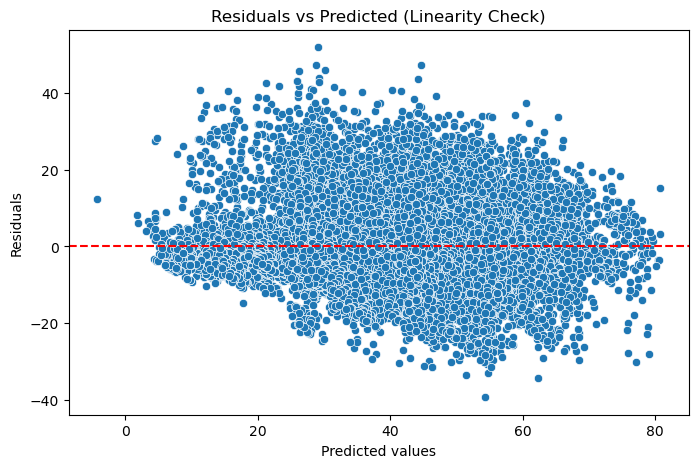

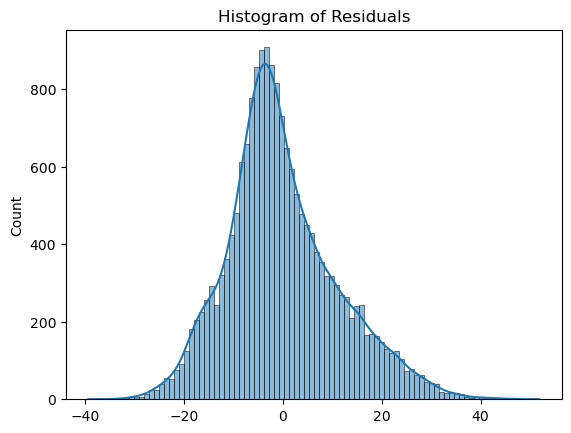

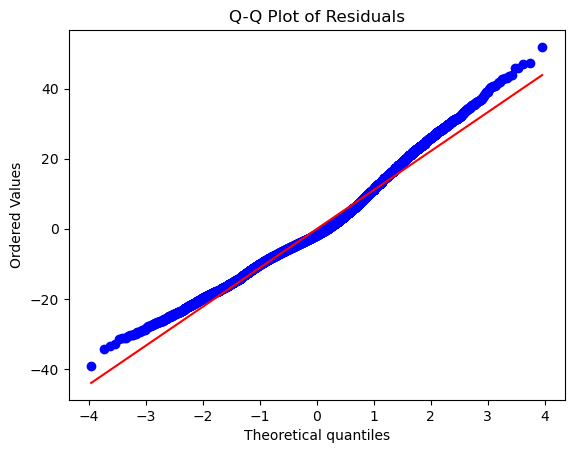

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Cleaned_Dataset.csv')

df = df.drop(columns=['Unnamed: 0', 'release_date', 'track_id', 'artists', 'album_name', 'track_name'])

# One-hot encode the 'track_genre' column
df = pd.get_dummies(df, columns=['track_genre'], drop_first=True)

# Define features and target
X = df.drop(columns=['popularity'])
y = df['popularity']

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# Set number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_array = X.values
y_array = y.values
feature_names = X.columns

train_r2_scores = []
test_r2_scores = []
mse_scores = []

best_model = None
best_test_r2 = -np.inf
best_coef = None

fold = 1
for train_index, test_index in kf.split(X_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)

    print(f"Fold {fold}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test  R²: {test_r2:.4f}")
    print(f"  Test  MSE: {mse:.2f}")
    print()

    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    mse_scores.append(mse)

    if test_r2 > best_test_r2:
        best_test_r2 = test_r2
        best_model = model
        best_coef = model.coef_

    fold += 1

# Summary stats
print("Cross-Validation Summary:")
print(f"Average Train R²: {np.mean(train_r2_scores):.4f}")
print(f"Average Test  R²: {np.mean(test_r2_scores):.4f}")
print(f"Average Test  MSE: {np.mean(mse_scores):.2f}")
print(f"Best Fold Test R²: {best_test_r2:.4f}")

# Feature importances from best model
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_coef,
    'Abs_Coefficient': np.abs(best_coef)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("\nTop 15 Important Features from Best Model:")
print(coef_df[['Feature', 'Coefficient']].head(15))

residuals = y_test - y_test_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Linearity Check)")
plt.show()

# Histogram
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q Plot
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

**Decision Trees**

Best Parameters: OrderedDict([('model__ccp_alpha', 0.05), ('model__max_depth', 40), ('model__min_samples_leaf', 4), ('model__min_samples_split', 50)])
Train R^2: 0.542537300524052
Test R^2: 0.5375273763246143
Test MSE: 147.5398925617451


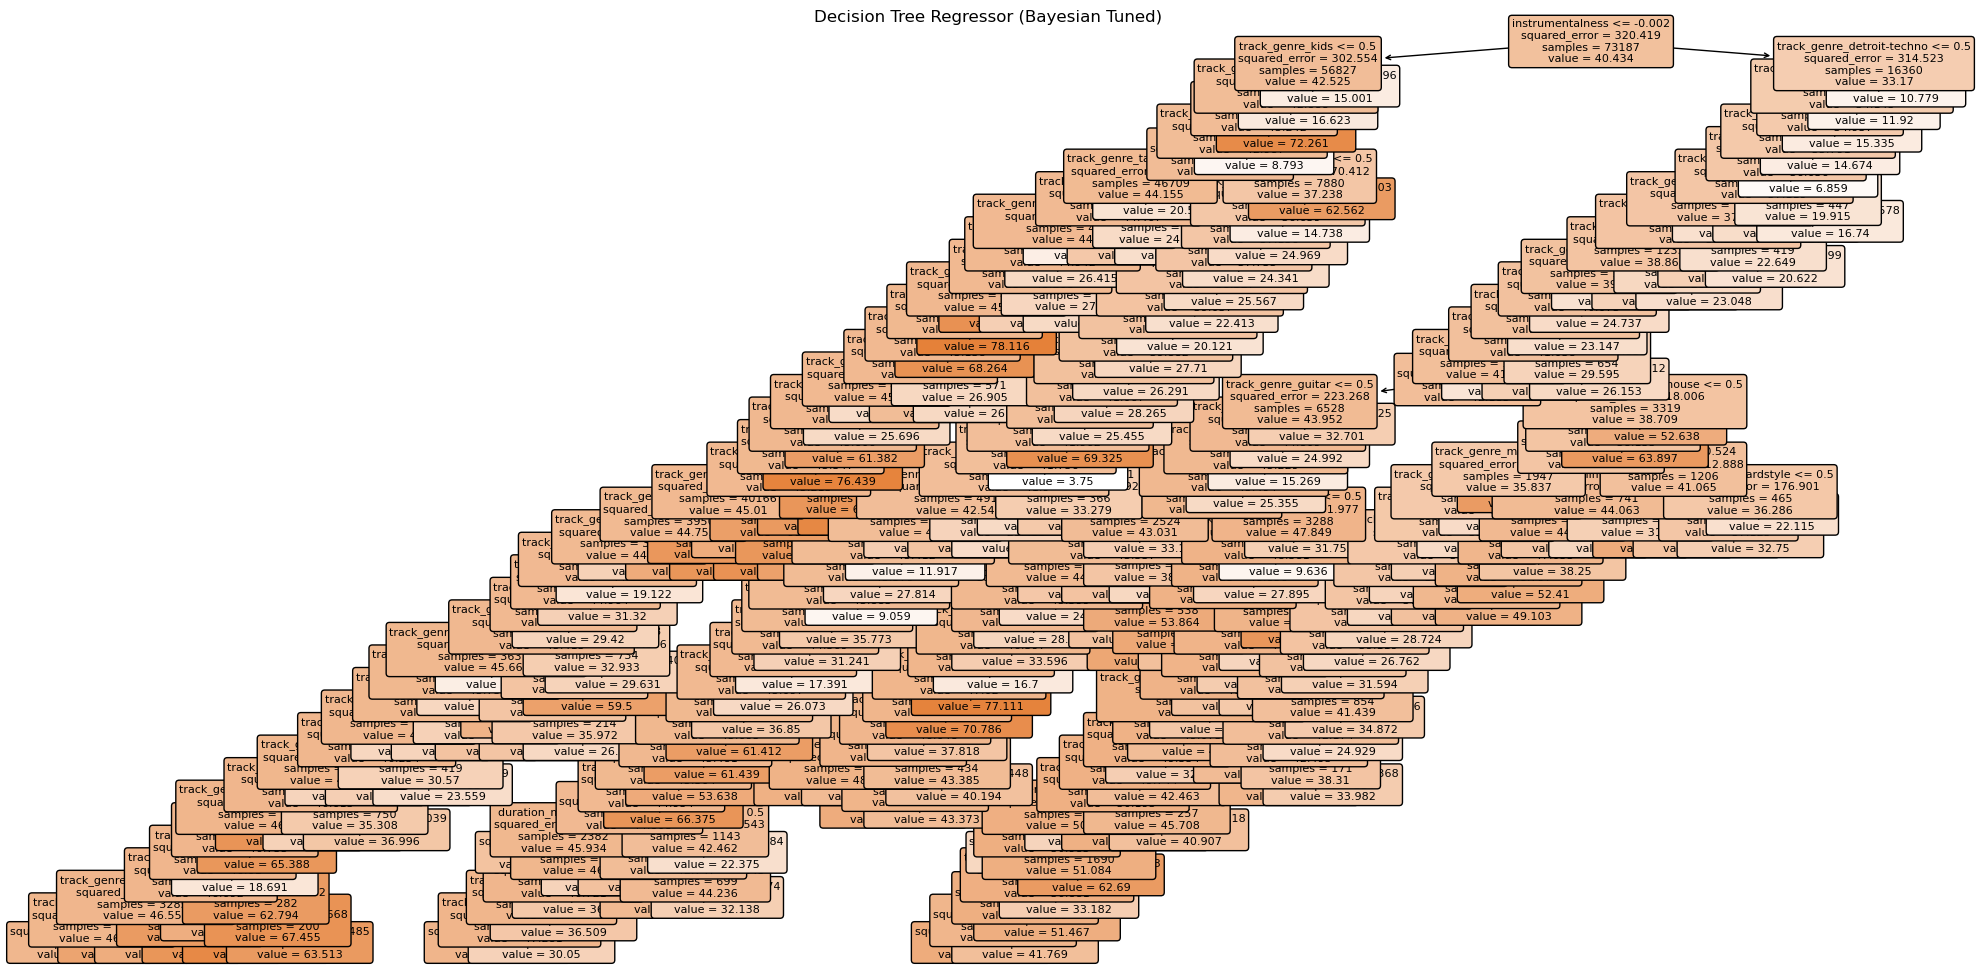

In [ ]:
# Regular Decision Tree using Bayesian Optimization to Find All Of The Best Parameters

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Real

df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

search_spaces = {
    'model__max_depth': Integer(5, 40),
    'model__min_samples_split': Integer(2, 50),
    'model__min_samples_leaf': Integer(1, 50),
    'model__ccp_alpha': Real(0.0, 0.05)
}

# Bayesian Optimization
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_train, y_train)
best_pipeline = opt.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

print("Best Parameters:", opt.best_params_)
print("Train R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

best_tree = best_pipeline.named_steps['model']
X_encoded = preprocessor.fit_transform(X_train)

ohe = preprocessor.named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

plt.figure(figsize=(24, 12))
plot_tree(best_tree, feature_names=feature_names, filled=True, rounded=True, fontsize=8)
plt.title(f"Decision Tree Regressor (Bayesian Tuned)")
plt.show()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

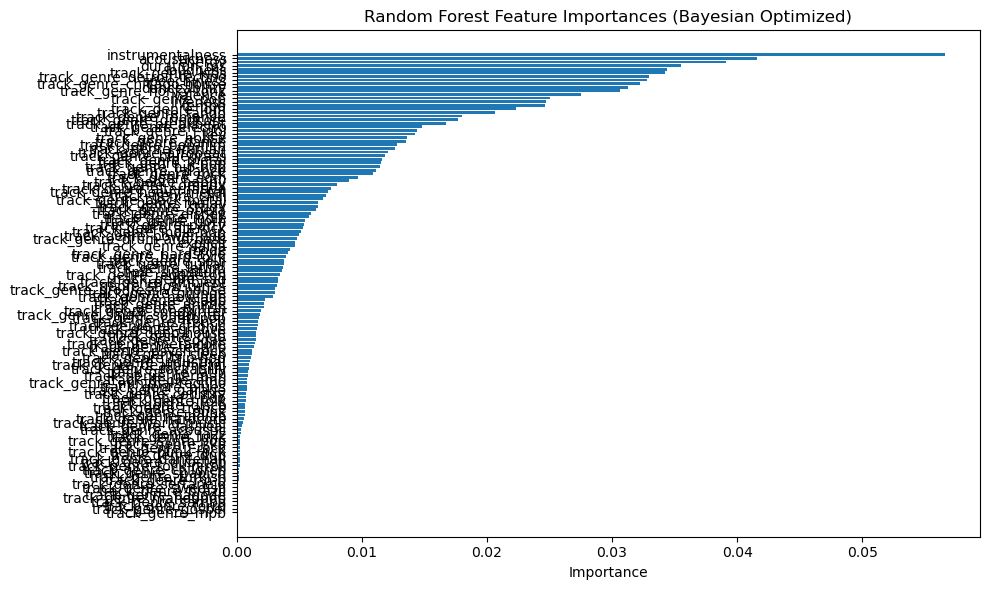

In [3]:
# Random Forest using Bayesian Optimization to Find All Of The Best Parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

search_space = {
    'model__n_estimators': Integer(100, 300),
    'model__max_depth': Integer(10, 40),
    'model__min_samples_leaf': Integer(1, 10),
    'model__min_samples_split': Integer(2, 10),
    'model__max_features': Categorical(['sqrt', 'log2'])
}

# Bayesian Optimization
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train, y_train)

best_pipeline = opt.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

print("Best Parameters:", opt.best_params_)
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

rf_model = best_pipeline.named_steps['model']
ohe = best_pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances (Bayesian Optimized)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

XGBoost Results:
Train R²: 0.9207801462947454
Test R²: 0.6897764166931877
Test MSE: 98.96878606015254


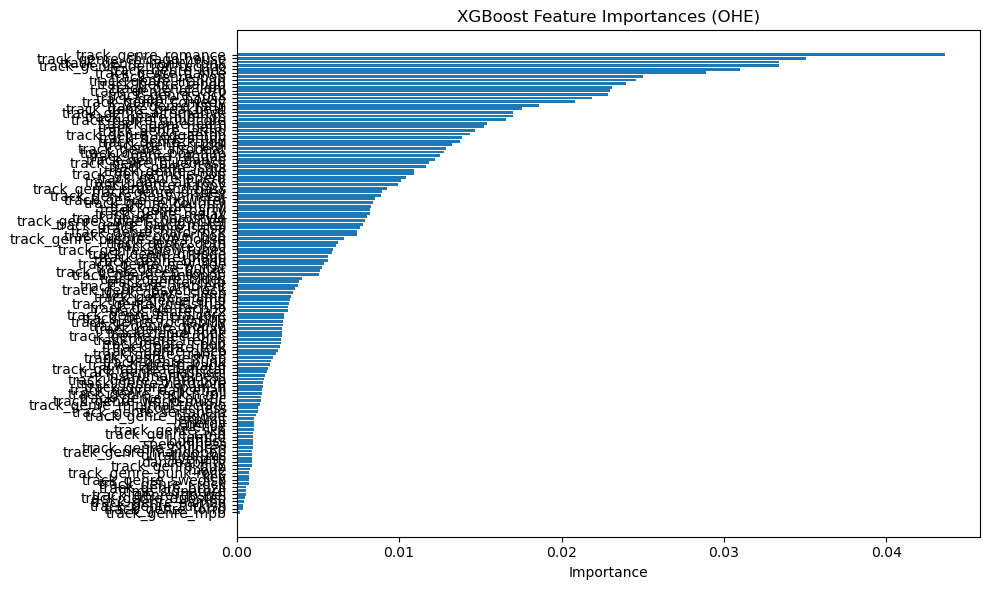

In [11]:
# XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Use best parameters from Bayesian search
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        colsample_bytree=0.5,
        learning_rate=0.07144343159553798,
        max_depth=15,
        n_estimators=500,
        reg_alpha=10.0,
        reg_lambda=10.0,
        subsample=0.5
    ))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

results = {
    "Train R²": r2_score(y_train, y_train_pred),
    "Test R²": r2_score(y_test, y_test_pred),
    "Test MSE": mean_squared_error(y_test, y_test_pred)
}

xgb_model = pipeline.named_steps['model']
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

print("XGBoost Results:")
for key, value in results.items():
    print(f"{key}: {value}")

plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importances (OHE)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

C:\Users\xayas\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagged Forest Results:
Best Parameters: OrderedDict([('model__base_estimator__max_depth', 30), ('model__base_estimator__min_samples_leaf', 4), ('model__n_estimators', 76)])
Train R²: 0.5827983107198438
Test R²: 0.5208868856796988
Test MSE: 152.84860939435237


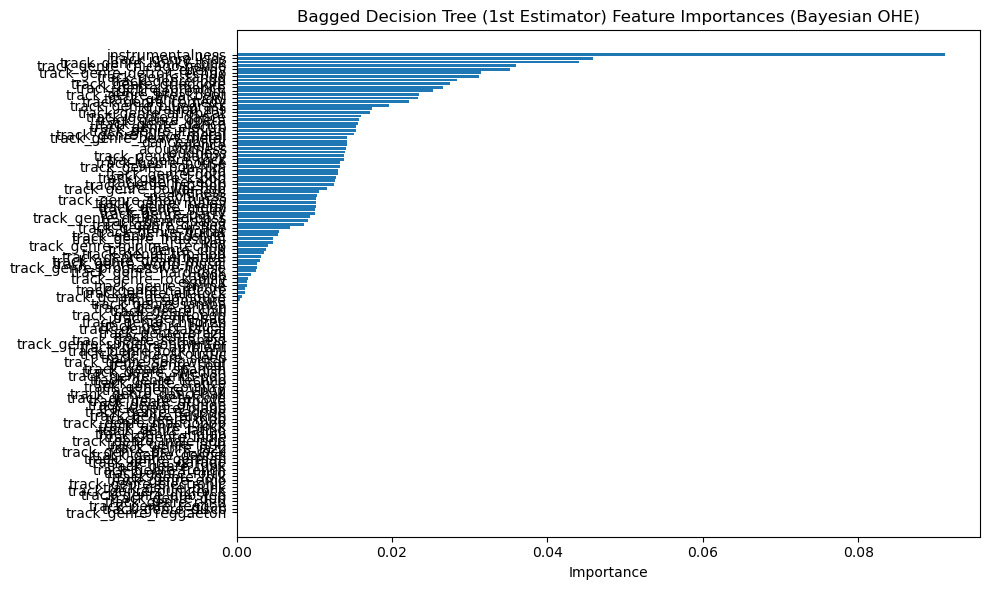

In [9]:
# Bagged Forest using Bayesian Optimization to Find All Of The Best Parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Integer

df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', BaggingRegressor(
        base_estimator=DecisionTreeRegressor(random_state=42),
        random_state=42,
        n_jobs=-1
    ))
])

search_spaces = {
    'model__n_estimators': Integer(10, 100),
    'model__base_estimator__max_depth': Integer(5, 30),
    'model__base_estimator__min_samples_leaf': Integer(1, 10)
}

# Bayesian Optimization
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

opt.fit(X_train, y_train)
best_pipeline = opt.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

results = {
    "Best Parameters": opt.best_params_,
    "Train R²": r2_score(y_train, y_train_pred),
    "Test R²": r2_score(y_test, y_test_pred),
    "Test MSE": mean_squared_error(y_test, y_test_pred)
}

first_tree = best_pipeline.named_steps['model'].estimators_[0]
ohe = best_pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = first_tree.feature_importances_
indices = np.argsort(importances)

print("Bagged Forest Results:")
for key, value in results.items():
    print(f"{key}: {value}")

plt.figure(figsize=(10, 6))
plt.title("Bagged Decision Tree (1st Estimator) Feature Importances (Bayesian OHE)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Winning Model: LightGBM**

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2798
[LightGBM] [Info] Number of data points in the train set: 73187, number of used features: 128
[LightGBM] [Info] Start training from score 40.433615
Train R^2: 0.9787177111964703
Test R^2: 0.7020088581668258
Test MSE: 95.06634295671988


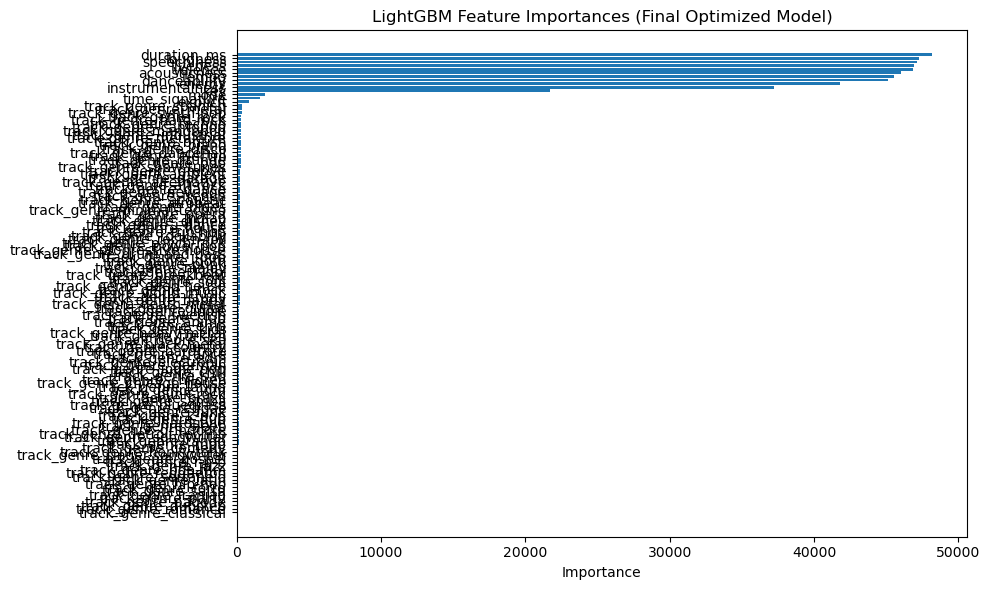

In [ ]:
# LightGBM 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Best parameters
model = LGBMRegressor(
    objective='regression',
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.42332053149109516,
    learning_rate=0.06674836528973682,
    max_depth=58,
    min_child_samples=17,
    n_estimators=1401,
    num_leaves=359,
    reg_alpha=3.7700247776742897,
    reg_lambda=3.779981995158376,
    subsample=0.9030923980367299
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print("Train R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

lgbm_model = pipeline.named_steps['model']
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)
importances = lgbm_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("LightGBM Feature Importances (Final Optimized Model)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Artificial Neural Network**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from scikeras.wrappers import KerasRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

df = pd.read_csv("Cleaned_Dataset.csv")

df_cleaned = df.drop(columns=[
    'Unnamed: 0', 'track_id', 'artists', 'album_name',
    'track_name', 'release_date'
])

X = df_cleaned.drop(columns=['popularity'])
y = df_cleaned['popularity']

categorical_features = ['explicit', 'track_genre']
numerical_features = X.drop(columns=categorical_features).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

def build_model(hidden1=64, hidden2=32, learning_rate=0.001):
    model = Sequential([
        Dense(hidden1, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(hidden2, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

def build_model(hidden1=64, hidden2=32, learning_rate=0.001):
    model = Sequential([
        Dense(hidden1, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(hidden2, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', KerasRegressor(model=build_model, verbose=0))
])

search_space = {
    'model__hidden1': Integer(32, 128),
    'model__hidden2': Integer(16, 64),
    'model__learning_rate': Real(1e-4, 1e-2, prior='log-uniform'),
    'model__batch_size': Categorical([16, 32, 64]),
    'model__epochs': Integer(10, 30)
}

opt = BayesSearchCV(
    pipeline,
    search_spaces=search_space,
    n_iter=20,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

opt.fit(X_train, y_train)

best_model = opt.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("Best Parameters:", opt.best_params_)
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: Invalid parameter hidden1 for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(hidden1=122)`
Check the list of available parameters with `estimator.get_params().keys()`